# 0. 한영 번역기 만들기

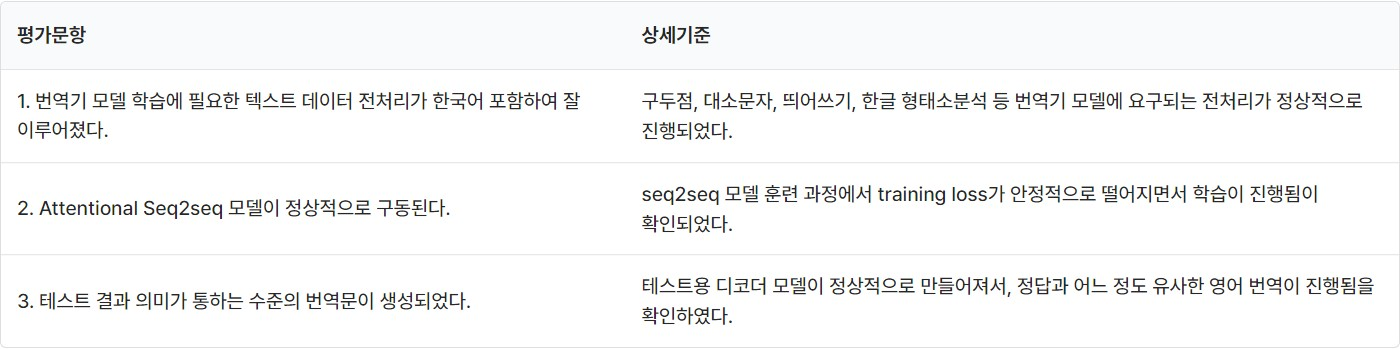

어텐션을 이용해 한영 번역기를 만들어보자...

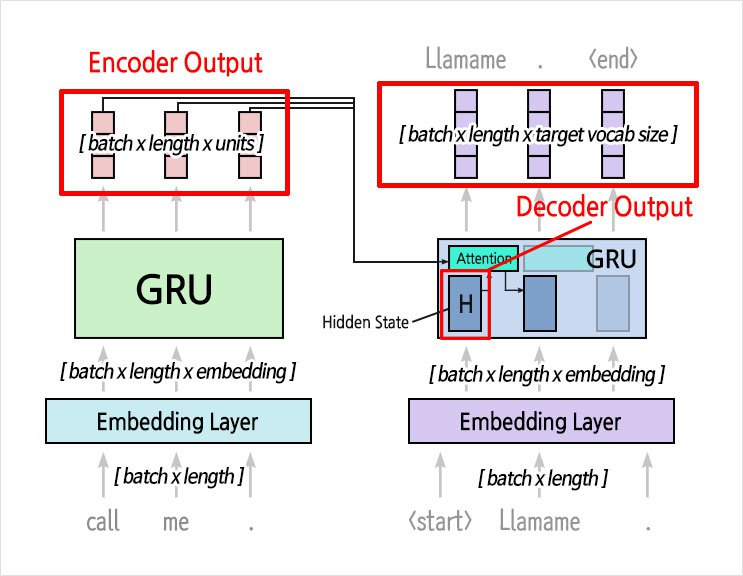

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io
import random
from tqdm import tqdm

from konlpy.tag import Mecab

In [2]:
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
tf.random.set_seed(9)
np.random.seed(9)
random.seed(9)

# 1. 데이터 다운로드

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보한다.  
https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

In [4]:
kor_path = './data/korean-english-park.train.ko'
eng_path = './data/korean-english-park.train.en'

In [5]:
with open(kor_path, "r") as f:
    raw_ko = f.read().splitlines()
            
with open(eng_path, "r") as f:
    raw_en = f.read().splitlines()

In [6]:
print("Data Size:", len(raw_ko))
print("Example:")

for sen in raw_ko[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [7]:
print("Data Size:", len(raw_en))
print("Example:")

for sen in raw_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


# 2. 데이터 정제

## 2.1. 중복 제거

In [8]:
cleaned_corpus = set(zip(raw_ko, raw_en))

In [9]:
print('중복 제거 전:', len(raw_ko))
print('중복 제거 후:', len(cleaned_corpus))

중복 제거 전: 94123
중복 제거 후: 78968


## 2.2. 데이터 전처리

In [10]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

## 2.3. 토큰화

In [11]:
mecab = Mecab()

In [12]:
preprocess_sentence('개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"')
                    

'개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐 ?'

In [13]:
kor_corpus = []
eng_corpus = []

for kor, eng in cleaned_corpus:
    kor_corpus.append(' '.join(mecab.morphs(preprocess_sentence(kor))))
    eng_corpus.append(preprocess_sentence(eng, s_token=True, e_token=True))

print("Korean:", kor_corpus[100])
print("English:", eng_corpus[100])

Korean: 일본 포경 활동 의 대변인 은 , 그린피스 의 행동 이 불법 적 인 것 이 며 , 사람 들 이 그 들 을 영웅시 해서 는 안 된다고 주장 했 다 .
English: <start> a spokesman for japan s whale hunt said greenpeace s actions were illegal and people should not treat them as heroes . <end>


## 2.4. 데이터 선별

In [14]:
def cal_sentence_length(raw):
    sen_lens = [len(sen.split()) for sen in raw]

    print("문장의 최단 길이:", min(sen_lens))
    print("문장의 최장 길이:", max(sen_lens))
    print("문장의 평균 길이:", sum(sen_lens) // len(raw))

    sentence_length = np.zeros((max(sen_lens)), dtype=np.int)

    for i in range(max(sen_lens)):
        sentence_length[i] += sen_lens.count(i)

    plt.bar(range(max(sen_lens)), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()

문장의 최단 길이: 0
문장의 최장 길이: 127
문장의 평균 길이: 29


/tmp/ipykernel_210/1005879321.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max(sen_lens)), dtype=np.int)


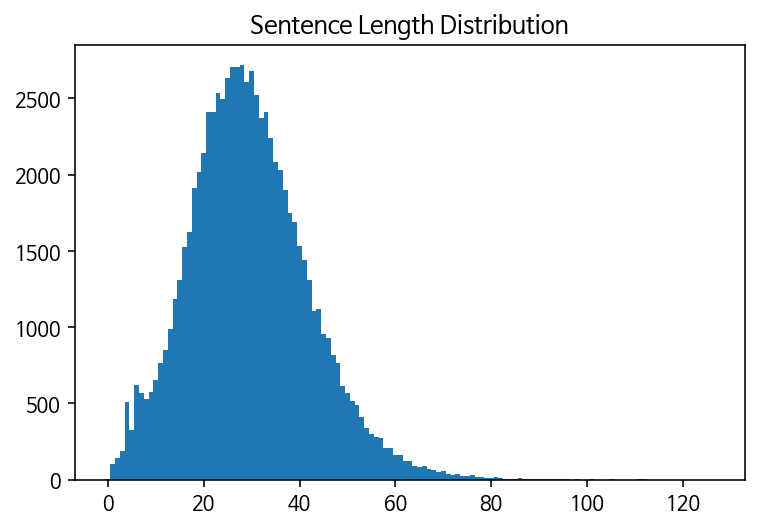

In [15]:
cal_sentence_length(kor_corpus)

문장의 최단 길이: 2
문장의 최장 길이: 101
문장의 평균 길이: 27


/tmp/ipykernel_210/1005879321.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max(sen_lens)), dtype=np.int)


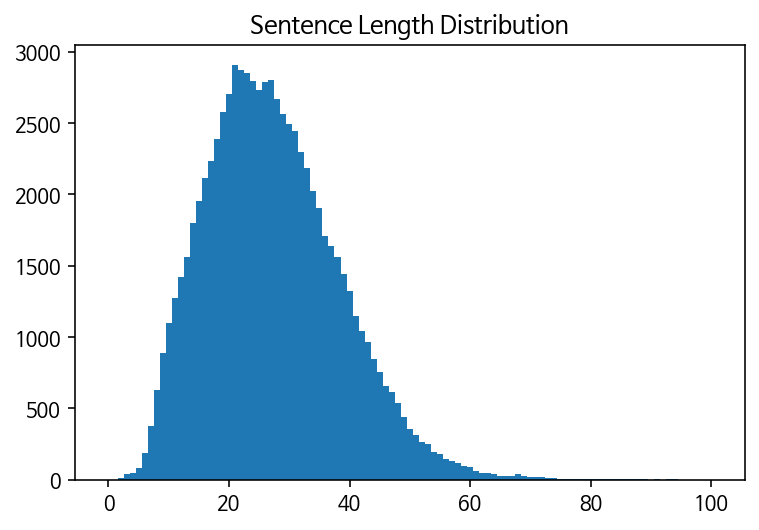

In [16]:
cal_sentence_length(eng_corpus)

In [17]:
corpus_df = pd.DataFrame(zip(kor_corpus, eng_corpus),
                         columns=['Korean', 'English'])

In [18]:
corpus_df

,Korean,English
0,사비네 힐 스첸 즈 42 는 8 명 의 영아 를 살해 한 후 독일 과 폴란드 국경 ...,"<start> sabine hilschenz , 42 , was convicted ..."
1,uefa 는 이 사회 를 열 어 응원단 의 비행 을 단속 하 기 위한 조치 로 마르...,<start> uefa could choose to stringently penal...
2,관리 들 은 북한 이 판문점 국경 마을 근처 에 있 는 공단 에서 근무 하 던 13...,<start> officials said pyongyang pulled out 11...
3,가이 는 이번 대회 남자 100 m 결승전 에서 지난 6 월 세운 기록 인 9 초 ...,<start> gay claimed his first world title in t...
4,특히 흥미 로운 한판 승부 후 관객 들 과 동참 해 앉 아 있 던 쿠션 을 멀리 던...,<start> although you may be tempted to join th...
...,...,...
78963,"그 다음 의 잠재 적 인 문제점 은 유료 tv , 즉 주문 비디오 의 점진 적 인 ...",<start> the second potential problem is the gr...
78964,드레서 의 연구 과제 는 집고양이 에게 복제 된 멸종 위기 야생 고양이 를 임신 시...,<start> dresser s projects include working to ...
78965,부토 가 암살 됨 에 따라 향후 있 을 정치 적 집회 에 대한 보안 은 강화 될 것...,<start> security will be tight at upcoming pol...
78966,사르코지 대통령 은 카다피 국가원수 와 회담 후 방명록 에 미래 를 논의 하 기 위...,<start> i am happy to be in your country to ta...


In [19]:
# point
min_len = 2
max_len = 40

In [20]:
OLD_LEN = len(corpus_df)

print('기존 샘플 수:', OLD_LEN)

corpus_df = corpus_df[corpus_df.apply(
    lambda x: (min_len <= len(x[0].split()) <= max_len)
    and (min_len+2 <= len(x[1].split()) <= max_len+2), axis=1)] # point

print('전체 샘플 수 :', len(corpus_df))
print('제거된 샘플 수:', OLD_LEN - len(corpus_df))

기존 샘플 수: 78968
전체 샘플 수 : 62037
제거된 샘플 수: 16931


In [21]:
kor_corpus = corpus_df['Korean'].to_list()
eng_corpus = corpus_df['English'].to_list()

문장의 최단 길이: 2
문장의 최장 길이: 40
문장의 평균 길이: 25


/tmp/ipykernel_210/1005879321.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max(sen_lens)), dtype=np.int)


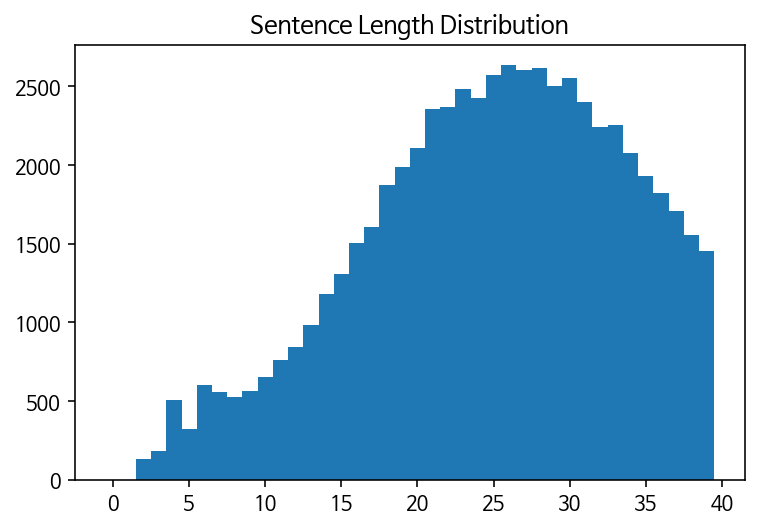

In [22]:
cal_sentence_length(kor_corpus)

문장의 최단 길이: 4
문장의 최장 길이: 42
문장의 평균 길이: 23


/tmp/ipykernel_210/1005879321.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sentence_length = np.zeros((max(sen_lens)), dtype=np.int)


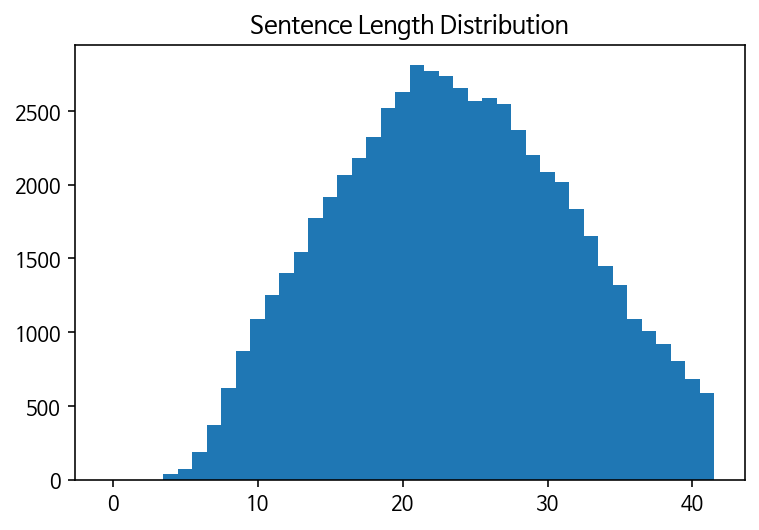

In [23]:
cal_sentence_length(eng_corpus)

# 3. 데이터 토큰화

In [24]:
def tokenize(corpus, num_words):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [25]:
# 토큰화하기
NUM_WORDS = 10000 # point
enc_tensor, enc_tokenizer = tokenize(kor_corpus, NUM_WORDS)
dec_tensor, dec_tokenizer = tokenize(eng_corpus, NUM_WORDS)

In [26]:
def tsize(train_X):
    length = len(train_X)
    return round(0.14 * (1 + length / 10 ** 4) ** (10 ** 4 / length) - 0.13, 2)

In [27]:
tsize(enc_tensor)

0.06

In [28]:
# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=tsize(enc_tensor))

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 45065
English Vocab Size: 39721


# 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 Attention 기반 Seq2seq 모델을 설계하자.

In [29]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        attn = tf.nn.softmax(score, axis=1)
        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [30]:
# point
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lnorm = tf.keras.layers.LayerNormalization()
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)
        self.drop = tf.keras.layers.Dropout(0.5)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.lnorm(out)
        out = self.gru(out)
        out = self.drop(out)
        
        return out

In [31]:
# point
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.attention = BahdanauAttention(dec_units)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lnorm = tf.keras.layers.LayerNormalization()
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True,
                                       return_state=True)
        self.drop = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        out = self.lnorm(out)
        out, h_dec = self.gru(out)
        out = self.drop(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [32]:
SRC_VOCAB_SIZE = NUM_WORDS + 1
TGT_VOCAB_SIZE = NUM_WORDS + 1

EMBEDDING_DIM = 2 ** 7 # point
UNITS         = 2 ** 9 # point
BATCH_SIZE    = 2 ** 5 # point

encoder = Encoder(SRC_VOCAB_SIZE, EMBEDDING_DIM, UNITS)
decoder = Decoder(TGT_VOCAB_SIZE, EMBEDDING_DIM, UNITS)

# sample input
SEQUENCE_LEN = 40

sample_enc = tf.random.uniform((BATCH_SIZE, SEQUENCE_LEN))
sample_output = encoder(sample_enc)

sample_state = tf.random.uniform((BATCH_SIZE, UNITS))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Encoder Input:', sample_enc.shape)
print ('Encoder Output:', sample_output.shape)

print ('Decoder Input:', sample_state.shape)
print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Input: (32, 40)
Encoder Output: (32, 40, 512)
Decoder Input: (32, 512)
Decoder Output: (32, 10001)
Decoder Hidden State: (32, 512)
Attention: (32, 40, 1)


# 5. 훈련하기

## 5.1. Optimizer & Loss

In [33]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [34]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 5.2. train_step 구현하기

In [35]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [36]:
# Define eval_step
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

## 5.3. 훈련 시작하기

In [37]:
# Training Process

EPOCHS = 6 # point

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  6: 100%|██████████| 117/117 [00:05<00:00, 21.92it/s, Test Loss 2.1905]


In [38]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


In [39]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [40]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 오바마는 대통령이다 .
Predicted translation: the georgia . <end> 


/tmp/ipykernel_210/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_210/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


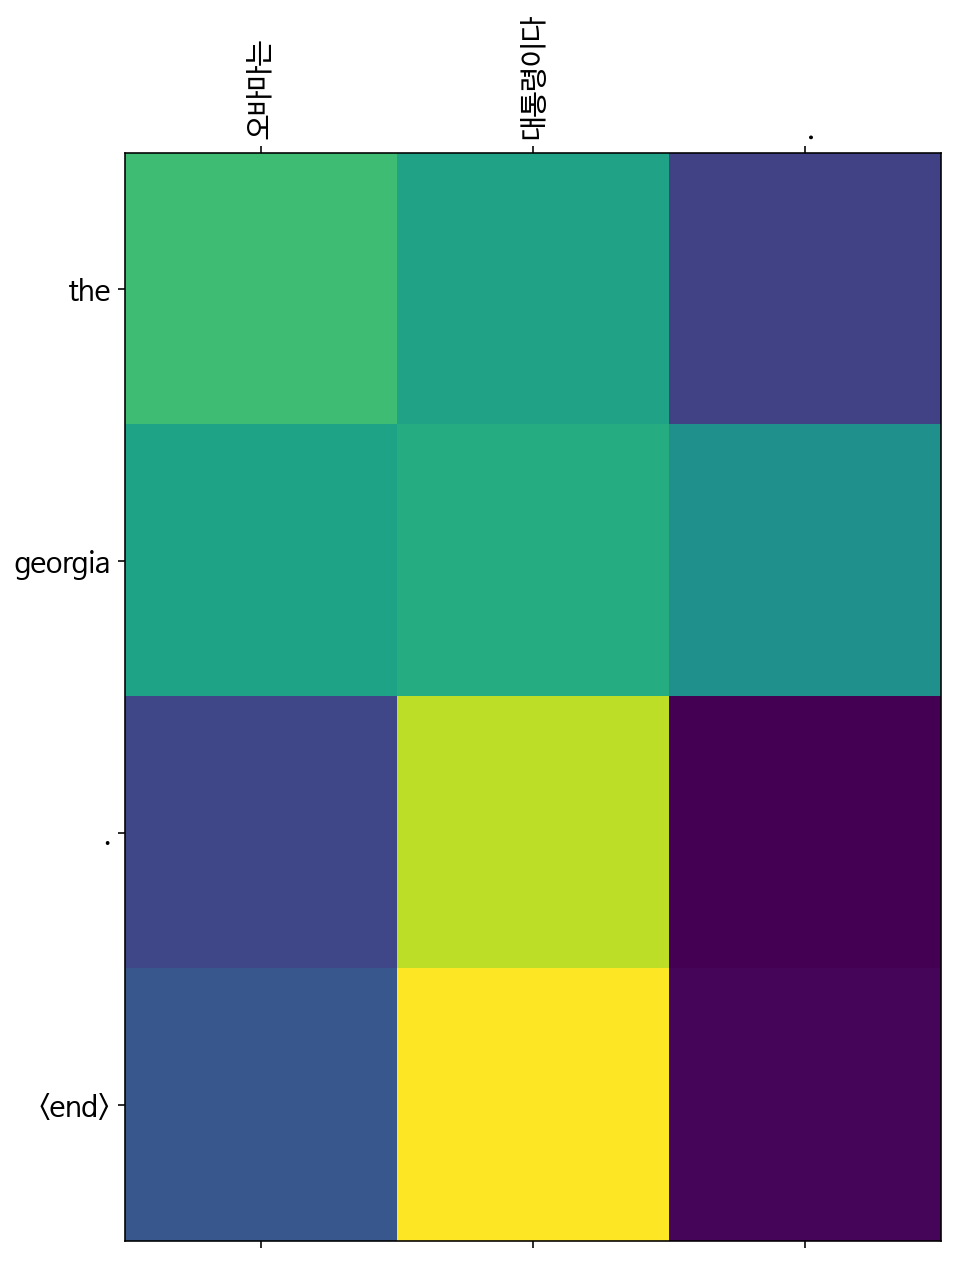

In [41]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다 .
Predicted translation: the city s . <end> 


/tmp/ipykernel_210/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_210/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


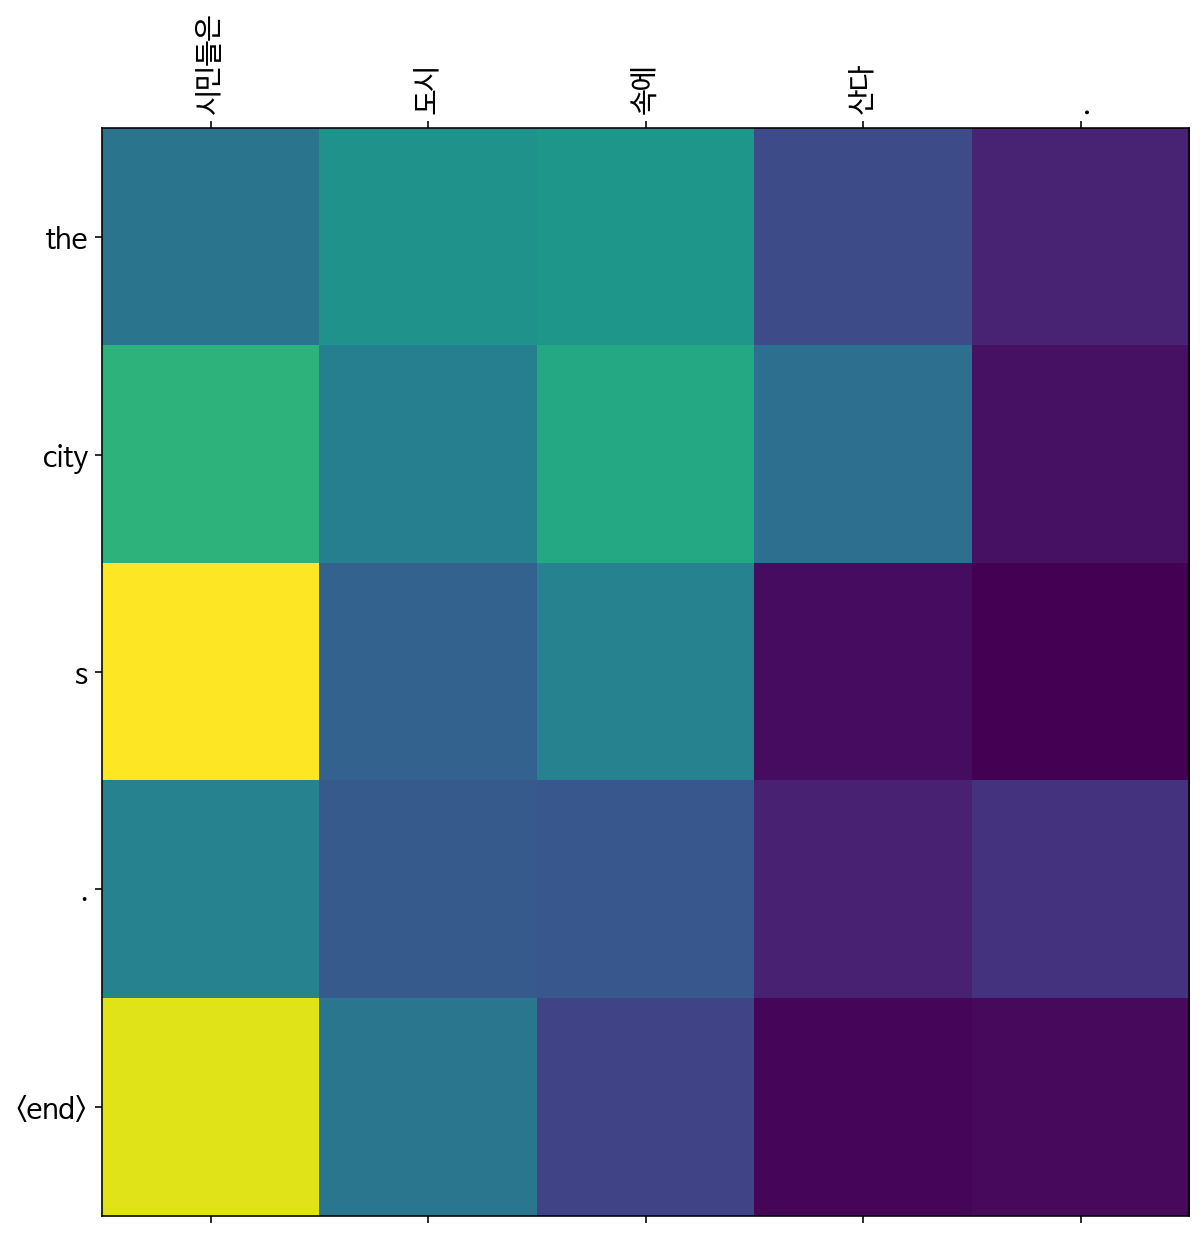

In [42]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요 없다 .
Predicted translation: we need to be a perfect summer . <end> 


/tmp/ipykernel_210/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_210/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


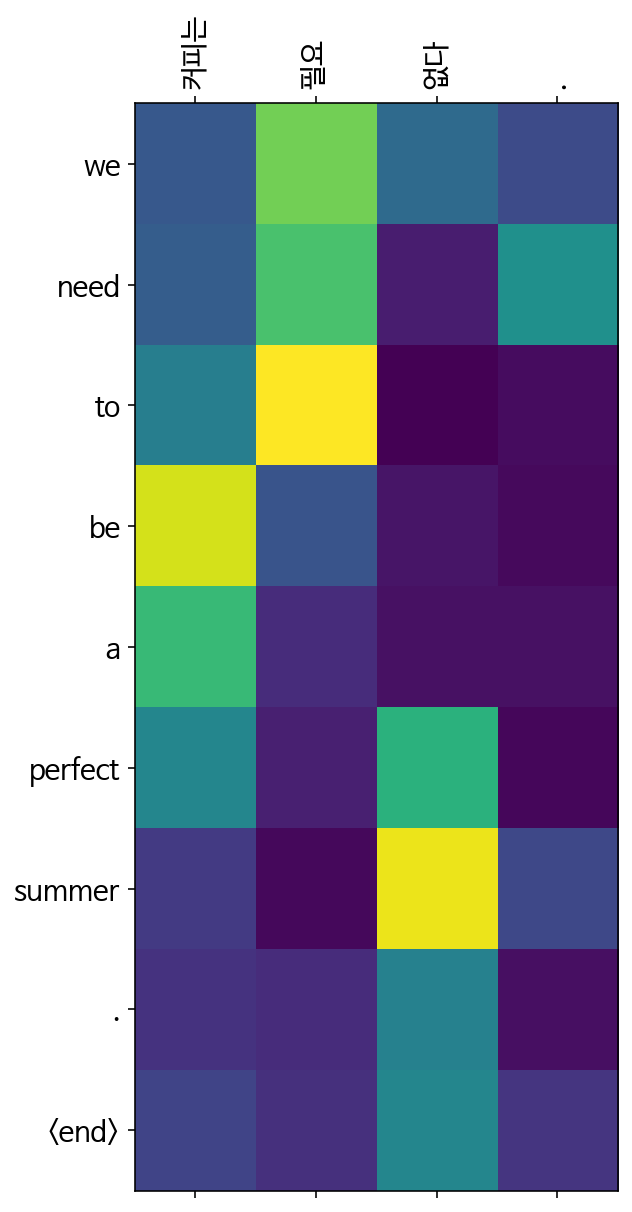

In [43]:
translate("커피는 필요 없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다 .
Predicted translation: seven <end> 


/tmp/ipykernel_210/421837482.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_210/421837482.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


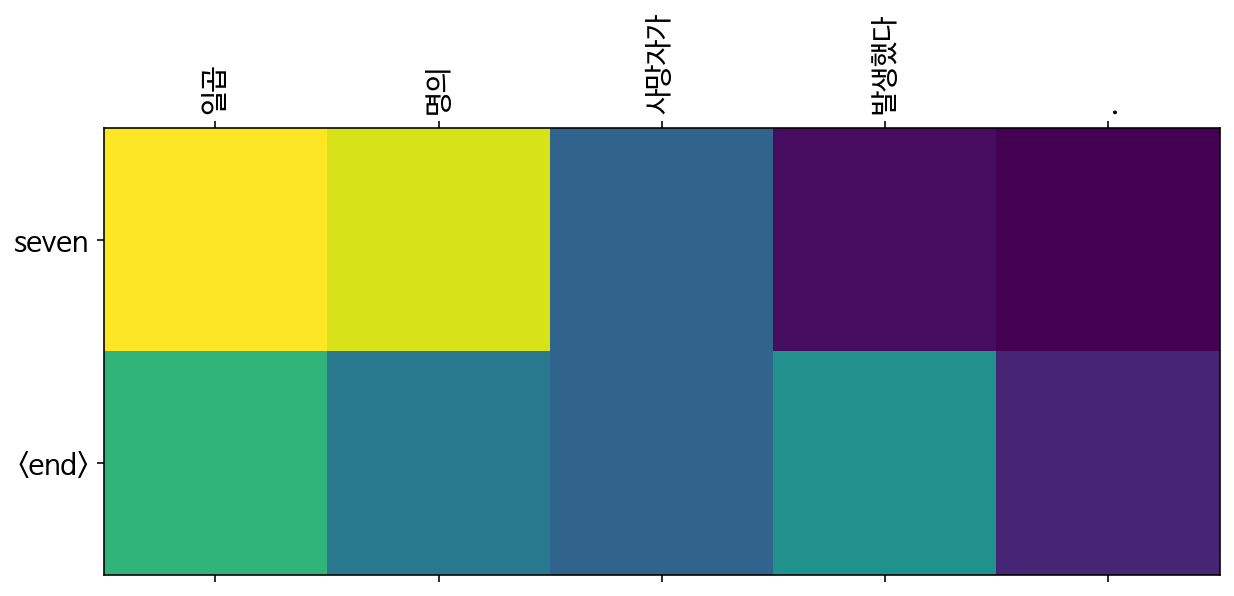

In [44]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

# 6. 회고하기

마크다운을 한 파일을 실수로 삭제해버렸다. 의욕이 사라져 버렸다.

하이퍼 퍼래머더를 아무리 변경해도 성능이 만족스럽지 않았다.  

전처리쪽 문제 같지만 엄두가 나지 않았다.  

다음에는 전처리에 신경을 써야될 것 같다.

+

올리고 봤더니 1~2번 문단이 사라져 있어서 다시 작성했다...

백업의 중요성도 깨달아 버렸다.